# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output

from tqdm import tqdm
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        nbPath = pathlib.Path.cwd()
        RepoPath = nbPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        import params
        mouse_defs = params.mouse_defs
        defs = mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root
        reload(dt)
        reload(defs)
        reload(params)
    finally:
        os.chdir(nbPath)
    
    
    %run "S1-mouse-M1-decoding.ipynb"
    
    print('Done!')

Done!


# Part 1

functions that plot each panel.


In [2]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

---

In [3]:
@utility.report
def plot_m1_decoding(ax, AllDFs):
    defs = mouse_defs
    
    reg_scores = []
    for i, df in enumerate(AllDFs):
        AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch_decode, area=defs.areas[0],
                                                      n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]

        *_,n_time,n_comp = AllData.shape
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]

        # resizing
        X1 = AllData1.reshape((-1, n_time, n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))

        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model.fit(x_train=x_train, y_train=y_train)
            lstm_model.predict(x_test, y_test)
            reg_scores.extend(lstm_model.score.tolist())

    pop_score_day = np.array(reg_scores)


    #=========================
    pairIndex_across = []
    for i, df1 in enumerate(AllDFs):
        animal1 = df1.mouse[0]
        pairIndex_across.append((i,[]))
        for j, df2 in enumerate(AllDFs):
            if j<i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]
    
    reg_scores_across = []
    for _, (id1, testId) in enumerate(pairIndex_across):
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch_decode,
                                                      area=defs.areas[0], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]


        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))
        AllVel2 = AllVel2.reshape((-1,n_time,3))

        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        U = U.reshape((-1,n_time,n_comp))
        V = V.reshape((-1,n_time,n_comp))

        lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
        lstm_model.fit(x_train=U, y_train=AllVel1)
        lstm_model.predict(V, AllVel2)
        reg_scores_across.extend(lstm_model.score.tolist())

    pop_score_across = np.array(reg_scores_across)

    #================================
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch_decode,
                                                      area=defs.areas[0], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape, AllData2.shape)),axis=0)
        X1 = AllData1.reshape((-1,n_time,n_comp))
        X2 = AllData2.reshape((-1,n_time,n_comp))
        AllVel2 = AllVel2.reshape((-1,n_time,3))
        AllVel1 = AllVel1.reshape((-1,n_time,3))
        crs_val_factor = int(0.9 * X1.shape[0])

        # train the decoder
        U,V = X1, X2
        lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
        lstm_model.fit(x_train=U[:crs_val_factor,...], y_train=AllVel1[:crs_val_factor,...])
        lstm_model.predict(V[:crs_val_factor,...], AllVel2[:crs_val_factor,...])
        reg_latent_scores.extend(lstm_model.score.tolist())
    pop_latent_score = np.array(reg_latent_scores)

#======================== PLOTTING

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label='Across\n' r'(\textit{aligned})',
            alpha=.8, color=params.colors.MainCC)
    ax.hist(pop_latent_score, bins=bins, density=True, label='Across\n' r'(\textit{unaligned})',
            alpha=.8, color=params.colors.LowerCC)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within',
            alpha=.8, color=params.colors.UpperCC)

    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.set_ylabel('Probability density', labelpad=1)
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])
    return pop_score_across

In [ ]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # allDFs_M1, _ = get_full_mouse_data()
    
    a = plot_m1_decoding(ax, allDFs_M1)
    
    plt.show()

# Part 2

Plot figure

Executed: `get_full_mouse_data` in 1.2s


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Executed: `plot_m1_decoding` in 630.2s


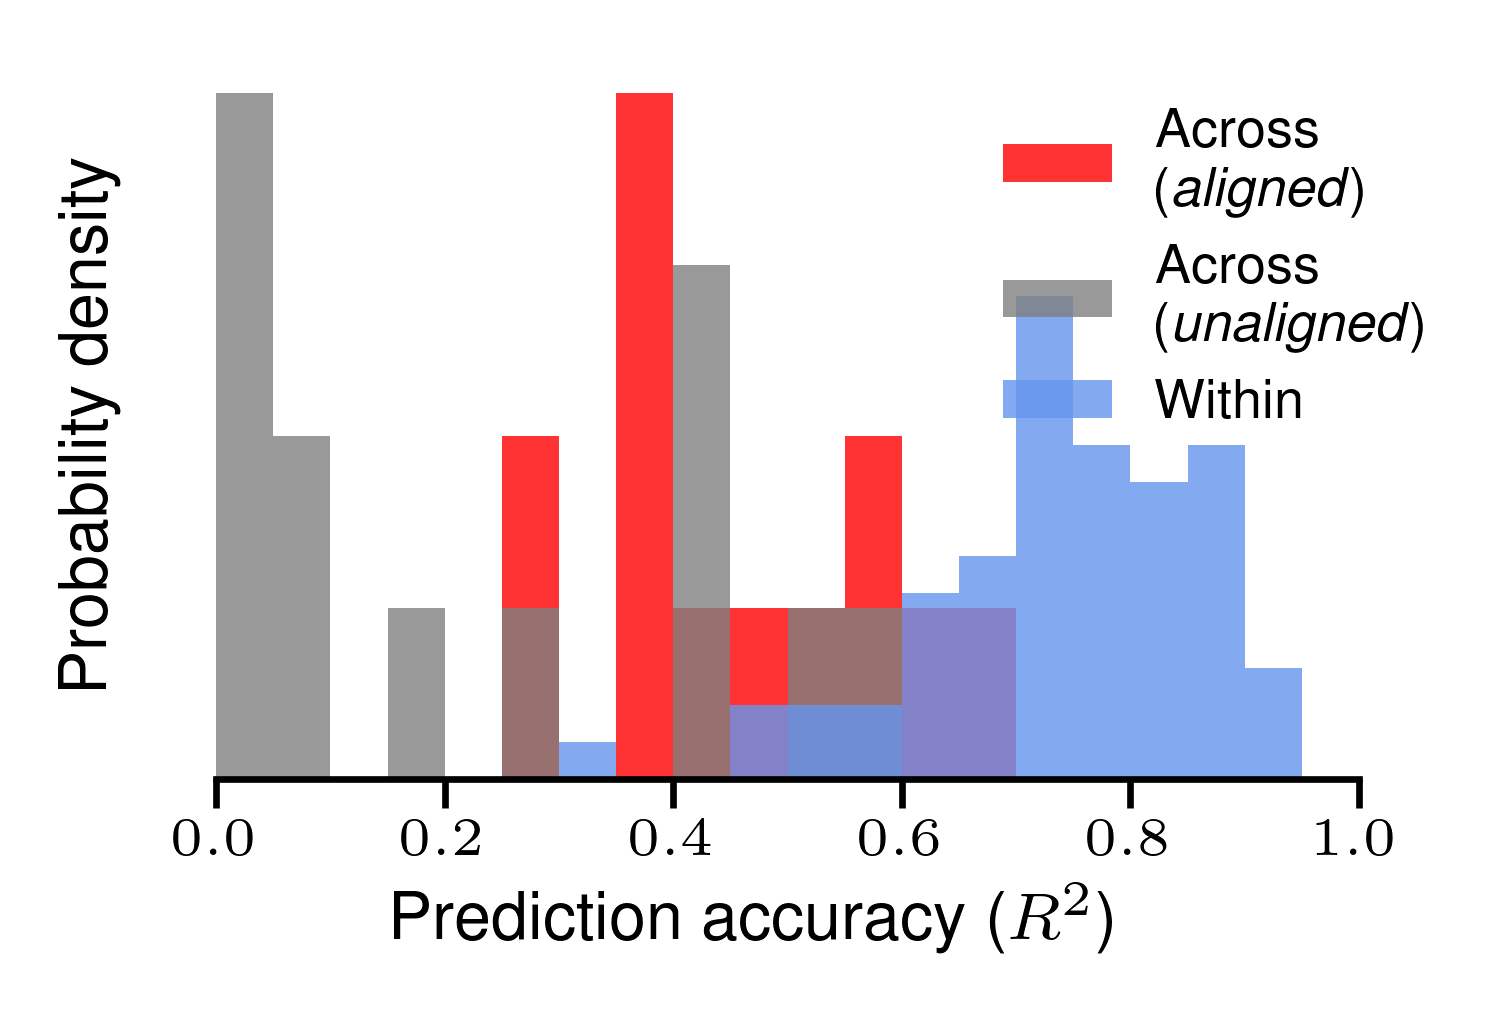

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= params.panels.decoding_hist
    fig=plt.figure(figsize=figsize)
    
   
    
    ##########################################
    # 1: Decoding for mouse M1
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=figsize[0],
                                    right=figsize[1],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax1 = fig.add_subplot(gs1[0])

       
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_m1_decoding(ax1, allDFs_M1)


    
    
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(ax1,ax2,ax3,ax4,ax5,ax6)
#     OFFX=np.array([.02]*len(AXES))
#     OFFY=np.array([.03]*len(AXES))
#     # OFFX[[-1]]=0.12
#     # OFFX[[1]]=0.06
    
#     params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS1-mouse-M1-decoding.pdf', format='pdf', bbox_inches='tight')